### Road Data

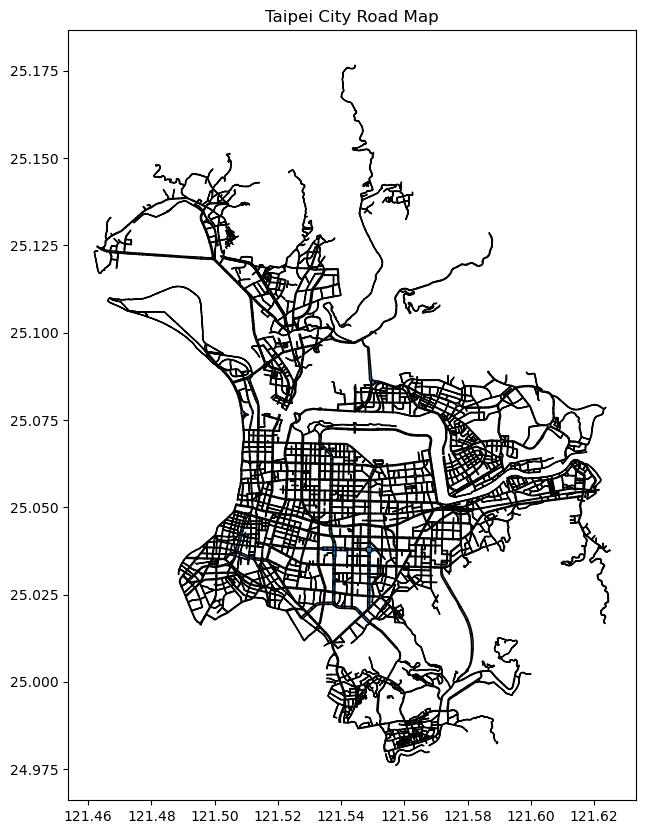

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [114]:
# !pip install geopandas
import geopandas as gpd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import json
import pandas as pd
from tqdm import tqdm

# Load shapefile
shapefile_path = "./data/8mroadup/Road.shp"  # Update with your path
gdf = gpd.read_file(shapefile_path, encoding='utf8')
gdf = gdf.to_crs("EPSG:4326")
# gdf = gdf.set_crs("EPSG:4326", allow_override = True)

# Basic plot
ax = gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title("Taipei City Road Map")

# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

plt.show()


gdf.crs


In [92]:
# 
# * Road Data
gdf.head()

,OBJECTID,RoadLenght,RoadWidth,Road_ID,TT,路名,TOWNNAME,漏繪,POINT_X,POINT_Y,...,驗收編,驗收方,交叉路,Shape_Leng,AVG,Max,Min,Shape_Le_1,Shape_Area,geometry
0,1,185.59400,17.5733,南深路-31,0,南深路,南港區,0.0,312886.4689,2.767871e+06,...,0,None,115-310,742.377544,185.594386,195.213503,175.975269,403.081653,2993.424945,"POLYGON ((121.62348 25.0182, 121.6234 25.01805..."
1,2,7.74174,0.0000,115-310,1,115,南港區,0.0,312921.1455,2.767944e+06,...,0,None,"南深路-30,南深路-31",30.966957,7.741739,7.743624,7.739854,44.380817,111.889402,"POLYGON ((121.62352 25.01826, 121.62351 25.018..."
2,3,8.49587,0.0000,115-309,1,115,南港區,0.0,312823.4883,2.768039e+06,...,0,None,"南深路-29,南深路-30",33.983474,8.495868,9.024670,7.967067,43.957454,105.725288,"POLYGON ((121.62249 25.01919, 121.62251 25.019..."
3,4,175.57100,14.5230,南深路-30,0,南深路,南港區,0.0,312909.2062,2.768024e+06,...,0,None,"115-309,115-310",702.282408,175.570602,184.151519,166.989685,378.568838,2494.033834,"POLYGON ((121.62292 25.01926, 121.62296 25.019..."
4,5,104.97600,15.7072,南深路-29,0,南深路,南港區,0.0,312798.3830,2.768108e+06,...,0,None,"115-308,115-309",419.902657,104.975664,109.324877,100.626451,239.578704,1573.980103,"POLYGON ((121.6222 25.02, 121.6222 25.01997, 1..."


### You Bike Data

Transform the Ubike JSON file into GeoPandas and visualize. (It takes 90 minutes.)

In [ ]:
# Load your JSON data
with open("data/ubike_stats.json", "r", encoding="utf-8") as f:
    ubike_data = json.load(f)

# Normalize the JSON data into a flat DataFrame
ubike_df = pd.DataFrame(columns = ['on_stop_id', 'off_stop_id', 'on_stop', 'off_stop', 'sum_of_txn_times', 'district_origin', 'district_destination', 'width', 'origin_x', 'origin_y', 'destination_x', 'destination_y'])

print("== Transforming JSON data into Pandas DataFrame... ==")
for element in tqdm(ubike_data['features']):
    ubike_df.loc[len(ubike_df), ubike_df.columns] = [
        element['properties']['on_stop_id'],
        element['properties']['off_stop_id'],
        element['properties']['on_stop'],
        element['properties']['off_stop'],
        element['properties']['sum_of_txn_times'],
        element['properties']['district_origin'],
        element['properties']['district_destination'],
        element['properties']['width'],
        element['geometry']['coordinates'][0][0],
        element['geometry']['coordinates'][0][1],
        element['geometry']['coordinates'][1][0],
        element['geometry']['coordinates'][1][1]
    ]
ubike_df.to_excel("./data/processed/ubike_stats_df.xlsx")

Calculate $D_j^{Org}$ and $D_j^{Dest}$ using `pandas.groupby()`

In [39]:
# 
# * Load Processed ubike data
ubike_df = pd.read_excel("data/processed/ubike_stats_df.xlsx") 

demands_origin = ubike_df.groupby('on_stop').agg({"origin_x": "mean", "origin_y": "mean", "sum_of_txn_times": "sum"}).reset_index().rename(columns = {"on_stop": "station", "sum_of_txn_times": "demand_origin"})

demands_destination = ubike_df.groupby('off_stop').agg({"destination_x": "mean", "destination_y": "mean", "sum_of_txn_times": "sum"}).reset_index().rename(columns = {"off_stop": "station", "sum_of_txn_times": "demand_destination"})

demands = pd.merge(demands_origin, demands_destination, on = 'station', how = 'inner')

demands = demands.rename(columns = {"origin_x": "x", "origin_y": "y"}).drop(["destination_x", "destination_y"],axis = 1)

demands['idx'] = demands.index + 1

In [40]:
demands['demands'] = demands['demand_destination'] + demands['demand_origin']
demands

,station,x,y,demand_origin,demand_destination,idx,demands
0,一壽橋,121.555480,24.978370,833,815,1,1648
1,一江公園,121.531460,25.053160,1528,1498,2,3026
2,三張犁,121.557600,25.034520,6206,6097,3,12303
3,三民公園,121.566679,25.061287,1063,1499,4,2562
4,三民公園(塔悠路),121.568310,25.062410,381,438,5,819
...,...,...,...,...,...,...,...
1284,龍山國小,121.495410,25.035500,968,1027,1285,1995
1285,龍江朱崙街口,121.540430,25.050040,1835,1806,1286,3641
1286,龍江錦州街口,121.540770,25.060450,3396,3354,1287,6750
1287,龍興里活動中心,121.511080,25.028150,1533,1814,1288,3347


In [41]:
# Convert x, y into Point geometries
geometry = [Point(xy) for xy in zip(demands['x'], demands['y'])]

# Convert to GeoDataFrame
demands_gdf = gpd.GeoDataFrame(demands, geometry = geometry)

# Check if it worked
demands_gdf.head()

,station,x,y,demand_origin,demand_destination,idx,demands,geometry
0,一壽橋,121.555480,24.978370,833,815,1,1648,POINT (121.55548 24.97837)
1,一江公園,121.531460,25.053160,1528,1498,2,3026,POINT (121.53146 25.05316)
2,三張犁,121.557600,25.034520,6206,6097,3,12303,POINT (121.5576 25.03452)
3,三民公園,121.566679,25.061287,1063,1499,4,2562,POINT (121.56668 25.06129)
4,三民公園(塔悠路),121.568310,25.062410,381,438,5,819,POINT (121.56831 25.06241)


### Built bike lane data


In [121]:
built_lanes = (pd.read_csv("./data/built_bike_lane.csv")[['路段序號', "路段名稱", "所屬道路寬度（M）", "路徑（X）", "路徑（Y）"]]
.rename(columns = {"路徑（Y）": "y_coords", '路徑（X）': 'x_coords'}))

built_lanes['x_coords'] = built_lanes['x_coords'].apply(lambda x: re.split(",|\#", x))
built_lanes['y_coords'] = built_lanes['y_coords'].apply(lambda y: re.split(",|\#", y))
built_lanes['geometry'] = built_lanes.apply(lambda row: LineString(list(zip(row['x_coords'], row['y_coords']))), axis=1)
built_lanes_gdf = gpd.GeoDataFrame(built_lanes, geometry = 'geometry').set_crs("EPSG:3826").to_crs("EPSG:4326")

built_lanes_gdf.head()



,路段序號,路段名稱,所屬道路寬度（M）,x_coords,y_coords,geometry
0,TP2329,三元街(西南側),15.0,"[301896.324, 301807.02, 301699.257, 301585.367...","[2768935.559, 2768932.562, 2768953.643, 276899...","LINESTRING (121.51424 25.02762, 121.51336 25.0..."
1,TP2330,文林北路75巷南側,8.0,"[301920.005, 302020.069, 302045.263, 302068.74...","[2777613.934, 2777531.129, 2777510.069, 277748...","LINESTRING (121.5148 25.10597, 121.51579 25.10..."
2,TP2331,明德路(北側),15.0,"[302370.317, 302347.695]","[2777985.291, 2777966.927]","LINESTRING (121.51928 25.10931, 121.51906 25.1..."
3,TP2332,重陽路興南街口,20.0,"[310883.404, 310962.103]","[2772298.799, 2772299.372]","LINESTRING (121.60344 25.05765, 121.60422 25.0..."
4,TP2333,民生圓環(民生東路與三民路口),22.0,"[306825.498, 306809.004, 306799.984, 306792.53...","[2772368.918, 2772380.259, 2772390.079, 277243...","LINESTRING (121.56322 25.05844, 121.56306 25.0..."


/var/folders/gl/stf2yn_54sdd_k_jlfmc4nvr0000gn/T/ipykernel_2097/3940775818.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


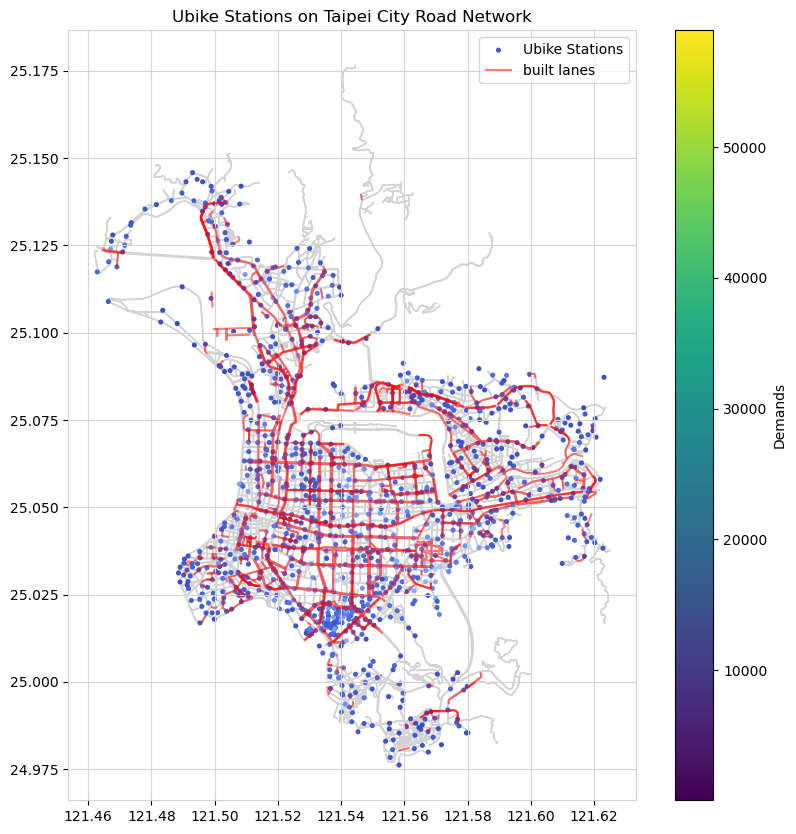

In [129]:
demands_gdf = demands_gdf.set_crs("EPSG:4326", allow_override=True)
demands_gdf = demands_gdf.to_crs("EPSG:4326")

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Road
gdf.plot(ax=ax, color='lightgrey', edgecolor='lightgrey', label = 'roads')

# Bike Stations
demands_gdf.plot(ax=ax, markersize=7, label='Ubike Stations', column='demand_origin', cmap='coolwarm')

# Built Lane
built_lanes_gdf.plot(ax=ax, color='red', edgecolor='orange', label = 'built lanes', alpha = 0.5)


# Add title and legend
ax.set_title("Ubike Stations on Taipei City Road Network")
ax.legend()

# Add colorbar (legend for color mapping)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=demands_gdf['demands'].min(), vmax=demands_gdf['demands'].max()))
sm.set_array([])  # empty array for colorbar
fig.colorbar(sm, ax=ax, label='Demands')

ax.grid(True, color = 'lightgray')

ax.spines['top'].set_color('lightgray')  # Top frame color
ax.spines['right'].set_color('lightgray')  # Right frame color
ax.spines['left'].set_color('lightgray')  # Left frame color
ax.spines['bottom'].set_color('lightgray')  # Bottom frame color
